# Evaluate How Robust Different Models are to Varying Degrees of Noise or Input Perturbation

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import snntorch.surrogate as surrogate

import os
import yaml
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score
from scipy.ndimage import gaussian_filter1d

from dataloader import train_test_val_split, get_dataset_statistics
from models import SpikingNetwork, TwoLayerSNN, ThreeLayerSNN
from utils.encoding import Rate_Encoder, Current_Encoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 0
device = 'cpu'
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed);

## Perturbation Functions

In [54]:
class RandomShift:
    def __init__(self, shift_range):
        self.shift_range = shift_range
    
    def __call__(self, x):
        # randomly shift an input torch tensor of size [B x N x D]. fill in new values with zeros
        # random translation is uniform within +- shift_range

        out = torch.zeros_like(x)
        shift = random.randint(-self.shift_range, self.shift_range)

        if shift > 0:
            out[:, shift:] = x[:, :-shift]
        elif shift < 0:
            out[:, :shift] = x[:, -shift:]
        else:
            return x.clone()
        
        return out

class GaussianNoise:
    def __init__(self, std):
        self.std = std
    
    def __call__(self, x):
        # add 0-centered random gaussian noise to an input tensor of arbitary size
        noise = torch.randn_like(x) * self.std
        return x + noise

## Model Performance Code

In [55]:
def get_binary_metrics(model, test_loader, encoder, threshold, perturb, device='cpu'):
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for data, target in test_loader:

            if encoder is not None:
                data = encoder.encode(data)

            data, target = data.to(device), target.to(device)
            data = perturb(data)

            output = model(data).squeeze(1)
    
            y_true.append(target.numpy())
            y_pred.append(output.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    auc = roc_auc_score(y_true, y_pred)

    y_pred = (y_pred  > threshold).astype(int)
    
    accuracy = (y_true == y_pred).mean()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    ppv = tp / (tp + fp + 1e-8)
    npv = tn / (tn + fn + 1e-8)

    return auc, accuracy, sensitivity, specificity, ppv, npv

## Get Model and Dataset from a Training Config File

In [ ]:
def get_model_and_dataset(train_config):
    # read in the paths to where to read from/to data
    with open('configs/paths.yaml', 'r') as file:
        path_configs = yaml.safe_load(file)

    # read in the instructions for how to train model
    with open(f'configs/model_configs/{train_config}', 'r') as file:
        train_configs = yaml.safe_load(file)

    # --- Create Datasets/DataLoaders --- #    
    binary = train_configs['binary']

    dataset_configs = {
        "data_file": os.path.join(path_configs['data_folder'], train_configs['dataset'], f"{train_configs['dataset']}.hdf5"),
        "metadata":  os.path.join(path_configs['data_folder'], train_configs['dataset'], f"{train_configs['dataset']}.csv"),
        "binary": binary,
        "random_state": 0,
        **train_configs['dataset_configs']
    }

    logging_configs={
        'model_name': train_configs['model_name'],
        'weight_folder': path_configs['weight_folder'],
        'log_folder': path_configs['log_folder'],
        'log_steps': train_configs['log_steps']
    }

    eval_batch_size = train_configs['eval_batch_size']

    train_dataset, _, test_dataset = train_test_val_split(**dataset_configs)
    train_mean, train_std = get_dataset_statistics(train_dataset)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size)

        # --- Model Configs --- #
    model_configs = train_configs['model_configs']
    if model_configs['neuron_options']['spike_grad'] == 'atan':
        model_configs['neuron_options']['spike_grad'] = surrogate.atan(alpha=2)

    if train_configs['model_class'] == 'TwoLayerSNN':
        model = TwoLayerSNN(**model_configs)
    else:
        model = SpikingNetwork(**model_configs)

    if train_configs['encoder'] == 'rate':
        encoder = Rate_Encoder(**train_configs['encoder_args'])
    else:
        encoder = Current_Encoder(train_mean, train_std)

    model_path = os.path.join(logging_configs['weight_folder'], logging_configs['model_name']) + '.pth'
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint['model'])

    threshold = None
    if binary:
        threshold = checkpoint['threshold']

    return model, test_loader, encoder, threshold


## Perturb Inputs and See How Models Perform

### Random Shift

In [63]:
shift_ranges = np.arange(start=0, stop=66, step=6)
shift_ranges

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60])

Evaluating Rate Coding Model


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Evaluating Current Coding Model


100%|██████████| 11/11 [00:25<00:00,  2.35s/it]


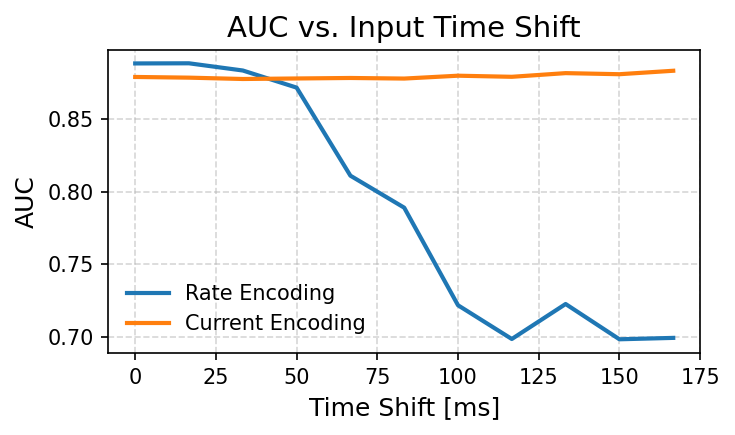

In [64]:
print('Evaluating Rate Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_rate_encoding.yaml')
rate_coding_results = []

for shift_range in tqdm(shift_ranges):
    perturb = RandomShift(shift_range)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    rate_coding_results.append((shift_range, model_metrics))
    

print('Evaluating Current Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
current_coding_results = []

for shift_range in tqdm(shift_ranges):
    perturb = RandomShift(shift_range)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    current_coding_results.append((shift_range, model_metrics))

shifts, rate_metrics = zip(*rate_coding_results)
rate_aucs = [rm[0] for rm in rate_metrics]

shifts, current_metrics = zip(*current_coding_results)
current_aucs = [rm[0] for rm in current_metrics]

shifts = np.array(shifts)
shifts = 1000 * shifts / 360

plt.figure(figsize=(5,3), dpi=150)
plt.plot(shifts, rate_aucs, label='Rate Encoding', linewidth=2, markersize=5)
plt.plot(shifts, current_aucs, label='Current Encoding', linewidth=2, markersize=5)

plt.xlabel('Time Shift [ms]', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC vs. Input Time Shift', fontsize=14)
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Random Noise

In [76]:
noise_stds = np.linspace(start=0, stop=1.0, num=10)
noise_stds

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

Evaluating Rate Coding Model


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Evaluating Current Coding Model


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


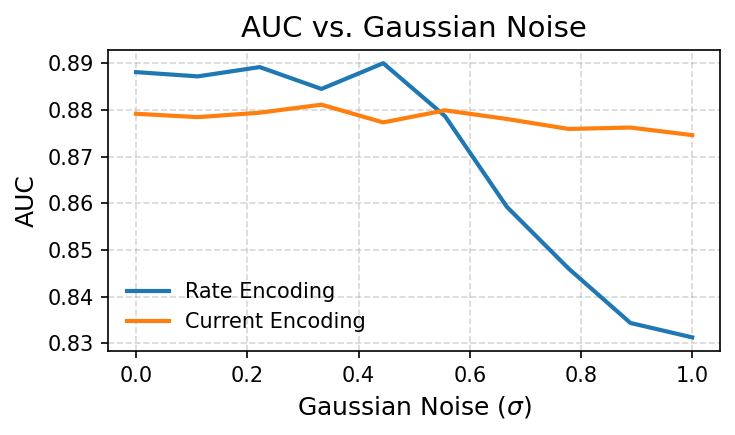

In [77]:
print('Evaluating Rate Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_rate_encoding.yaml')
rate_coding_results = []

for noise_std in tqdm(noise_stds):
    perturb = GaussianNoise(noise_std)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    rate_coding_results.append((noise_std, model_metrics))
    

print('Evaluating Current Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
current_coding_results = []

for noise_std in tqdm(noise_stds):
    perturb = GaussianNoise(noise_std)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    current_coding_results.append((noise_std, model_metrics))

stds, rate_metrics = zip(*rate_coding_results)
rate_aucs = [rm[0] for rm in rate_metrics]

stds, current_metrics = zip(*current_coding_results)
current_aucs = [rm[0] for rm in current_metrics]

stds = np.array(stds)

plt.figure(figsize=(5,3), dpi=150)
plt.plot(stds, rate_aucs, label='Rate Encoding', linewidth=2, markersize=5)
plt.plot(stds, current_aucs, label='Current Encoding', linewidth=2, markersize=5)

plt.xlabel('Gaussian Noise ($\sigma$)', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC vs. Gaussian Noise', fontsize=14)
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Visualize Spiking Activity With a Current-Encoding Network

In [92]:
def infer(model, encoder, data):
    # run a model for a single example
    data = encoder.encode(data).unsqueeze(0)
    output, z0, z1 = model(data)
    return output.squeeze(), z0, z1

In [87]:
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
model.logging_mode = True
test_dataset = test_loader.dataset

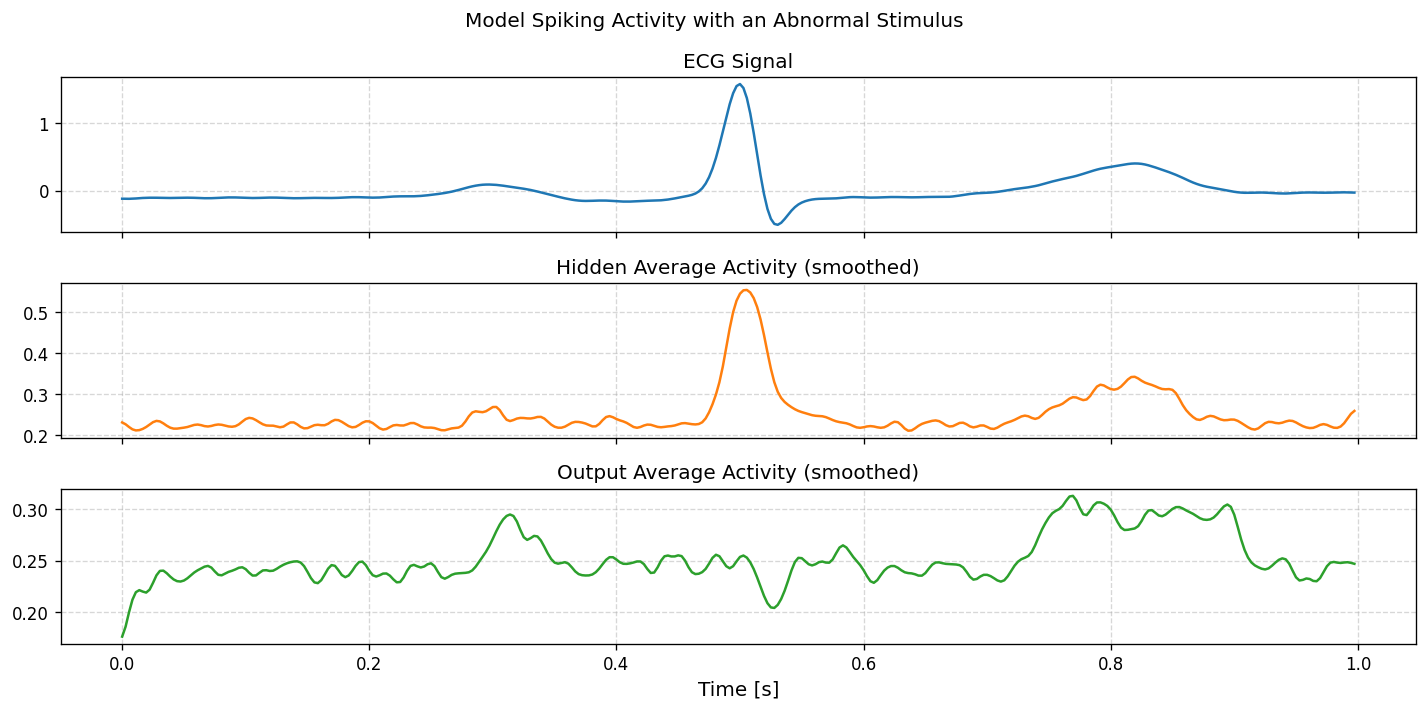

In [142]:
# 4, 120: good abnormal
# 5: good normal
x, label = test_dataset[5]
y_raw, z0, z1 = infer(model, encoder, x)

z0_avg = z0.squeeze().mean(1)
z1_avg = z1.squeeze().mean(1)

y = int(y_raw > threshold)

time = np.arange(len(x)) / 360

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, dpi=120)

fig.suptitle('Model Spiking Activity with an Abnormal Stimulus')

axes[0].plot(time, x, color='C0')
axes[0].set_title('ECG Signal', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(time, gaussian_filter1d(z0_avg, 2), color='C1')
axes[1].set_title('Hidden Average Activity (smoothed)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].plot(time, gaussian_filter1d(z1_avg, 2), color='C2')
axes[2].set_title('Output Average Activity (smoothed)', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

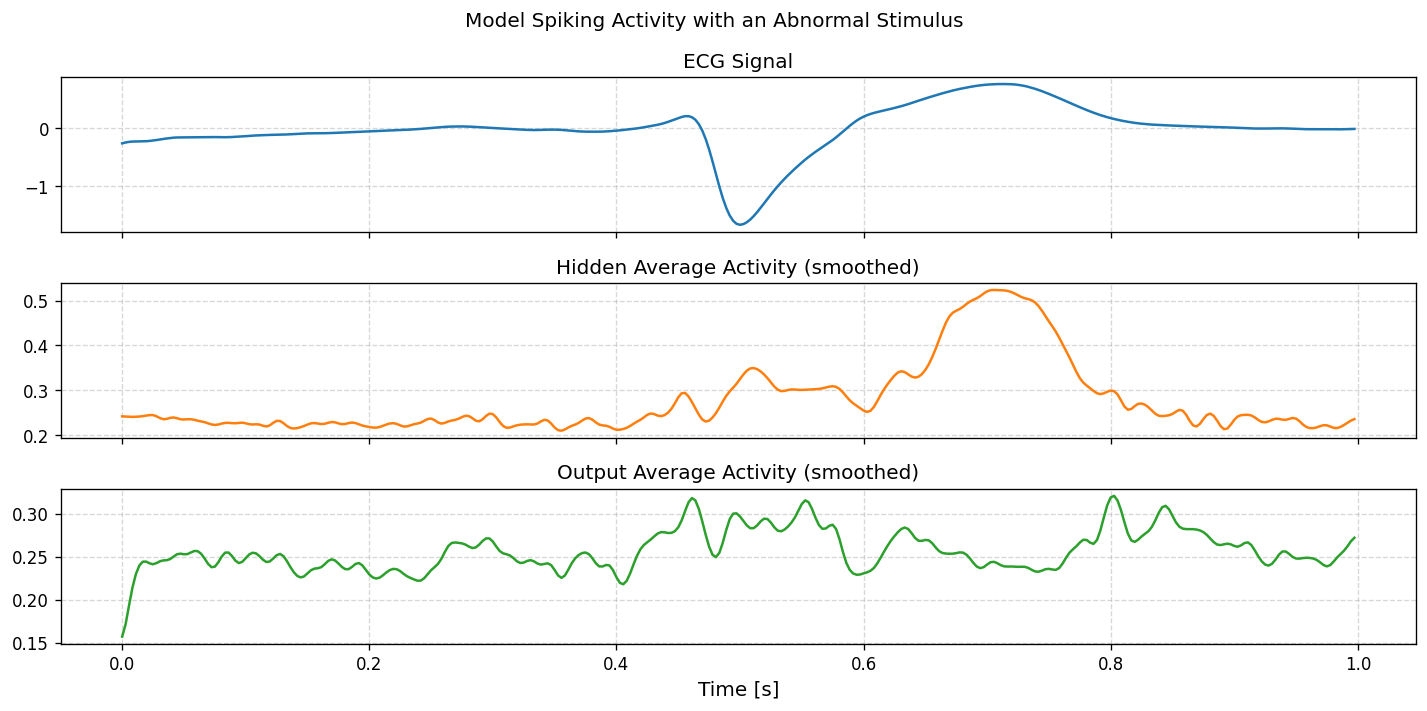

In [143]:
# 4, 120: good abnormal
# 5: good normal
x, label = test_dataset[120]
y_raw, z0, z1 = infer(model, encoder, x)

z0_avg = z0.squeeze().mean(1)
z1_avg = z1.squeeze().mean(1)

y = int(y_raw > threshold)

time = np.arange(len(x)) / 360

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, dpi=120)

fig.suptitle('Model Spiking Activity with an Abnormal Stimulus')

axes[0].plot(time, x, color='C0')
axes[0].set_title('ECG Signal', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(time, gaussian_filter1d(z0_avg, 2), color='C1')
axes[1].set_title('Hidden Average Activity (smoothed)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].plot(time, gaussian_filter1d(z1_avg, 2), color='C2')
axes[2].set_title('Output Average Activity (smoothed)', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

array([0.22384718, 0.2224578 , 0.22023869, 0.2180656 , 0.21678501,
       0.21690618, 0.21848002, 0.22110094, 0.22404942, 0.22649248,
       0.22773504, 0.2274666 , 0.22585705, 0.22347787, 0.22106104,
       0.21921282, 0.21826276, 0.21823184, 0.21892893, 0.22004957,
       0.22124848, 0.22221777, 0.22277066, 0.2229291 , 0.22289106,
       0.22289495, 0.22304797, 0.22326957, 0.22337887, 0.22328286,
       0.22311492, 0.22323295, 0.2240554 , 0.22582753, 0.22843292,
       0.23135734, 0.23384684, 0.23519728, 0.23505054, 0.23351899,
       0.23109858, 0.22841397, 0.22599025, 0.22412124, 0.22292478,
       0.22244856, 0.22269376, 0.22350805, 0.22448891, 0.22507629,
       0.2248444 , 0.2237887 , 0.22236514, 0.22122768, 0.22083671,
       0.22126217, 0.22227183, 0.22359422, 0.22511707, 0.22684059,
       0.22865976, 0.2302266 , 0.23104541, 0.23073795, 0.22933431,
       0.22732449, 0.22547054, 0.22446331, 0.22460814, 0.22566281,
       0.2269447 , 0.22763692, 0.22717392, 0.22550875, 0.22313